In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results

import numpy as np
import pandas as pd

import os

from config import plt_config
plt.rcParams.update(plt_config)

load model

In [3]:
from config import mod5_params
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod5_nk.gcn'), verbose=True)
plot_vars = ['Y', 'C', 'L', 'w', 'r', 'pi']

Model Building Complete.
Found:
	19 equations
	19 variables
	1 stochastic shock
		 0 / 1 has a defined prior. 
	8 parameters
		 0 / 8 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [4]:
mod.blocks

{'TECHNOLOGY_SHOCKS': <gEconpy.classes.block.Block at 0x22447ccaa60>,
 'HOUSEHOLD': <gEconpy.classes.block.Block at 0x224481fc640>,
 'FIRM': <gEconpy.classes.block.Block at 0x224228c7ee0>,
 'PRICE_SETTING': <gEconpy.classes.block.Block at 0x224481fc6a0>,
 'EQUILIBRIUM': <gEconpy.classes.block.Block at 0x2244ac0f280>}

In [5]:
mod.variables

[A_t,
 C_t,
 I_t,
 K_t,
 L_t,
 MC_t,
 P_hat_t,
 P_t,
 Pi_t,
 Q_t,
 TC_t,
 U_t,
 Y_t,
 g1_t,
 lambda_t,
 pi_t,
 q_t,
 r_t,
 w_t]

In [7]:
# assign parameters
mod.free_param_dict.update(mod5_params)
mod.free_param_dict

{'Theta': 0.75,
 'alpha': 0.35,
 'beta': 0.985,
 'delta': 0.025,
 'psi': 8,
 'rho_A': 0.95,
 'sigma_C': 2,
 'sigma_L': 1.5}

Investigate priors

Solve

In [8]:
%time mod.steady_state()

Steady state found! Sum of squared residuals is 9.94596370737411e-23
CPU times: total: 3.47 s
Wall time: 4.34 s


In [9]:
# steady state values
mod.print_steady_state()

A_ss               1.000
C_ss               0.739
I_ss               0.039
K_ss               1.547
L_ss               0.537
MC_ss              0.421
P_hat_ss           1.842
P_ss               1.842
Pi_ss              1.105
Q_ss               1.842
TC_ss             -0.328
U_ss             -95.825
Y_ss               0.778
g1_ss              1.612
lambda_ss          0.993
pi_ss              1.000
q_ss               1.830
r_ss               0.074
w_ss               0.396


In [10]:
mod.solve_model(solver="gensys")

[0, 1, 0]
Norm of deterministic part: 1.045800850
Norm of stochastic part:    1.045800850


In [11]:
mod.check_bk_condition()
;

Model solution has 6 eigenvalues greater than one in modulus and 4 forward-looking variables.
Blanchard-Kahn condition is satisfied.


''

In [12]:
# # policy matrix
# for name, policy_matrix in zip(["T", "R"], [round(mod.T, 5), round(mod.R, 5)]):
#     print(name.center(10).center(50, "="))
#     print(policy_matrix.to_string())

Model stats

''

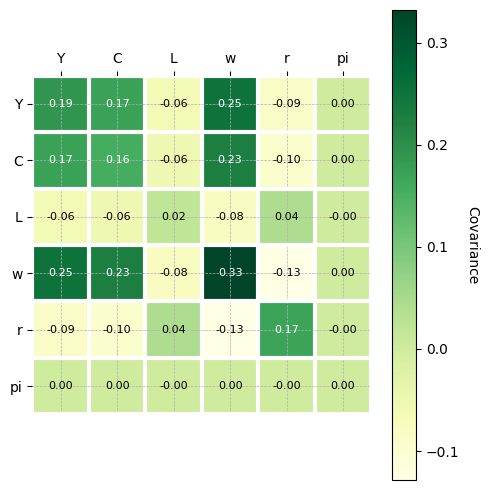

In [13]:
scov = mod.compute_stationary_covariance_matrix()
gp.plot_covariance_matrix(scov, plot_vars,
                          figsize=(5,5))
;

''

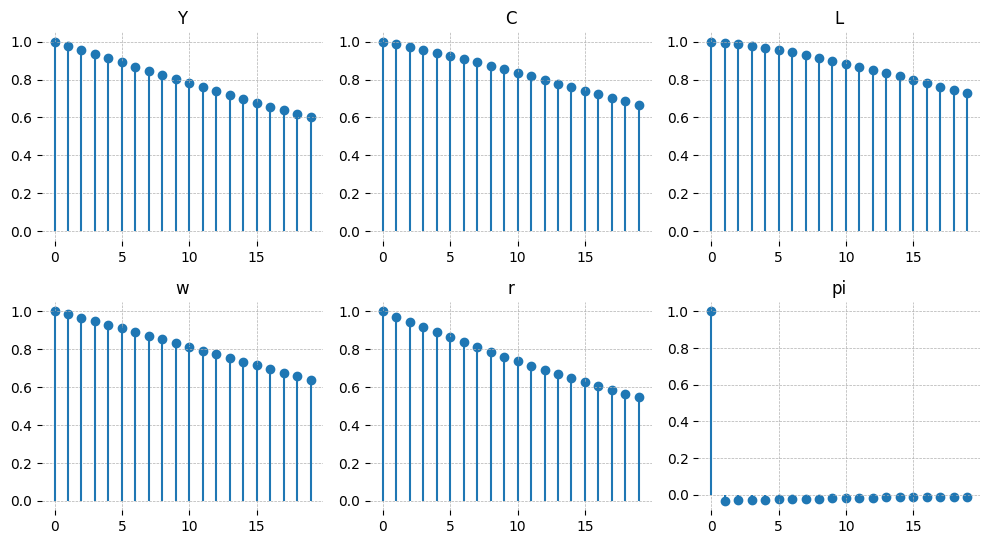

In [14]:
acorr = mod.compute_autocorrelation_matrix(n_lags=20)
gp.plot_acf(acorr, plot_vars, n_cols=3, figsize=(10, 8))
;

IRF

In [15]:
irf = mod.impulse_response_function(simulation_length=40, shock_size=1.0)
_irf = irf.copy().unstack().loc[:, "epsilon_A"].unstack()

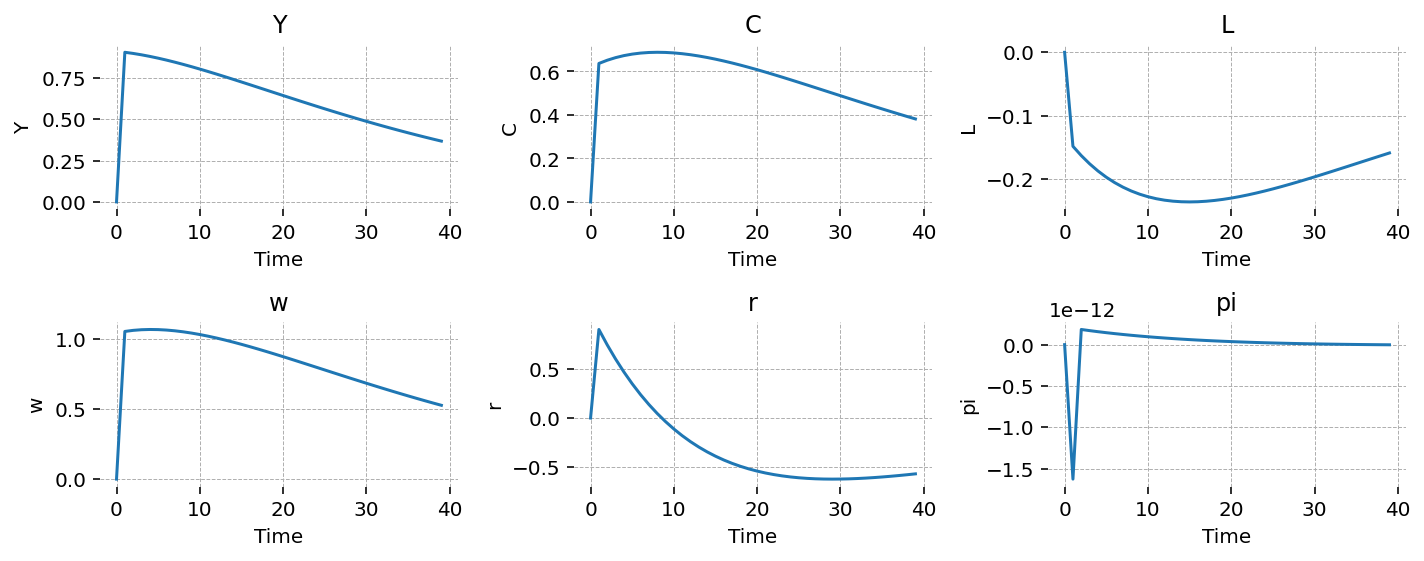

In [19]:
plot_dfs(_irf[plot_vars], sns.lineplot, figsize=(10, 2))

Estimation

In [22]:
from config import recession_dict

df = pd.read_csv(os.path.join(DATA_DIR, 'prepro_data.csv'), index_col='date').drop('Unnamed: 0', axis=1)
df.index = pd.to_datetime(df.index)
df = df.asfreq('QS')

In [23]:
df = df.rename(columns={'pi_s': 'pi'}).drop(['pi_c', 'Ix', 'Zx'], axis=1)
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

In [31]:
StatsMod = compile_to_statsmodels(mod)

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
        'Y':0.01,
        # 'w':0.02
}

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
}
mod_stats = StatsMod(train[["Y"]],
                 param_start_dict = param_start_dict,
                  shock_start_dict = shock_start_dict,
                  noise_start_dict = noise_start_dict,
                  param_transforms = param_transforms,
                  shock_transforms=None, 
                  noise_transforms=None, 
                  initialization='stationary')

In [32]:
%%capture
# basinhopping as algorithm, mixes different approaches 
mod_res = mod_stats.fit(method='basinhopping')

In [33]:
mod_res.summary()

C:\Users\LukasGrahl\Documents\GIT\memoire1\env_memoire1\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2979: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   53
Model:                      DSGEModel   Log Likelihood                 -27.777
Date:                Tue, 14 Feb 2023   AIC                             61.554
Time:                        09:31:55   BIC                             67.465
Sample:                    04-01-2006   HQIC                            63.827
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.8500         -0       -inf      0.000       0.850       0.850
sigma2.epsilon_A     0.5000         -0       -inf      0.000       0.500       0.500
sigma2.Y             0.0100         -0       -inf      0.000       0.010       0.010
===================================================================================
Ljung-Box (L1) (Q):                   9.08   Jarque-Bera (JB):                51.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

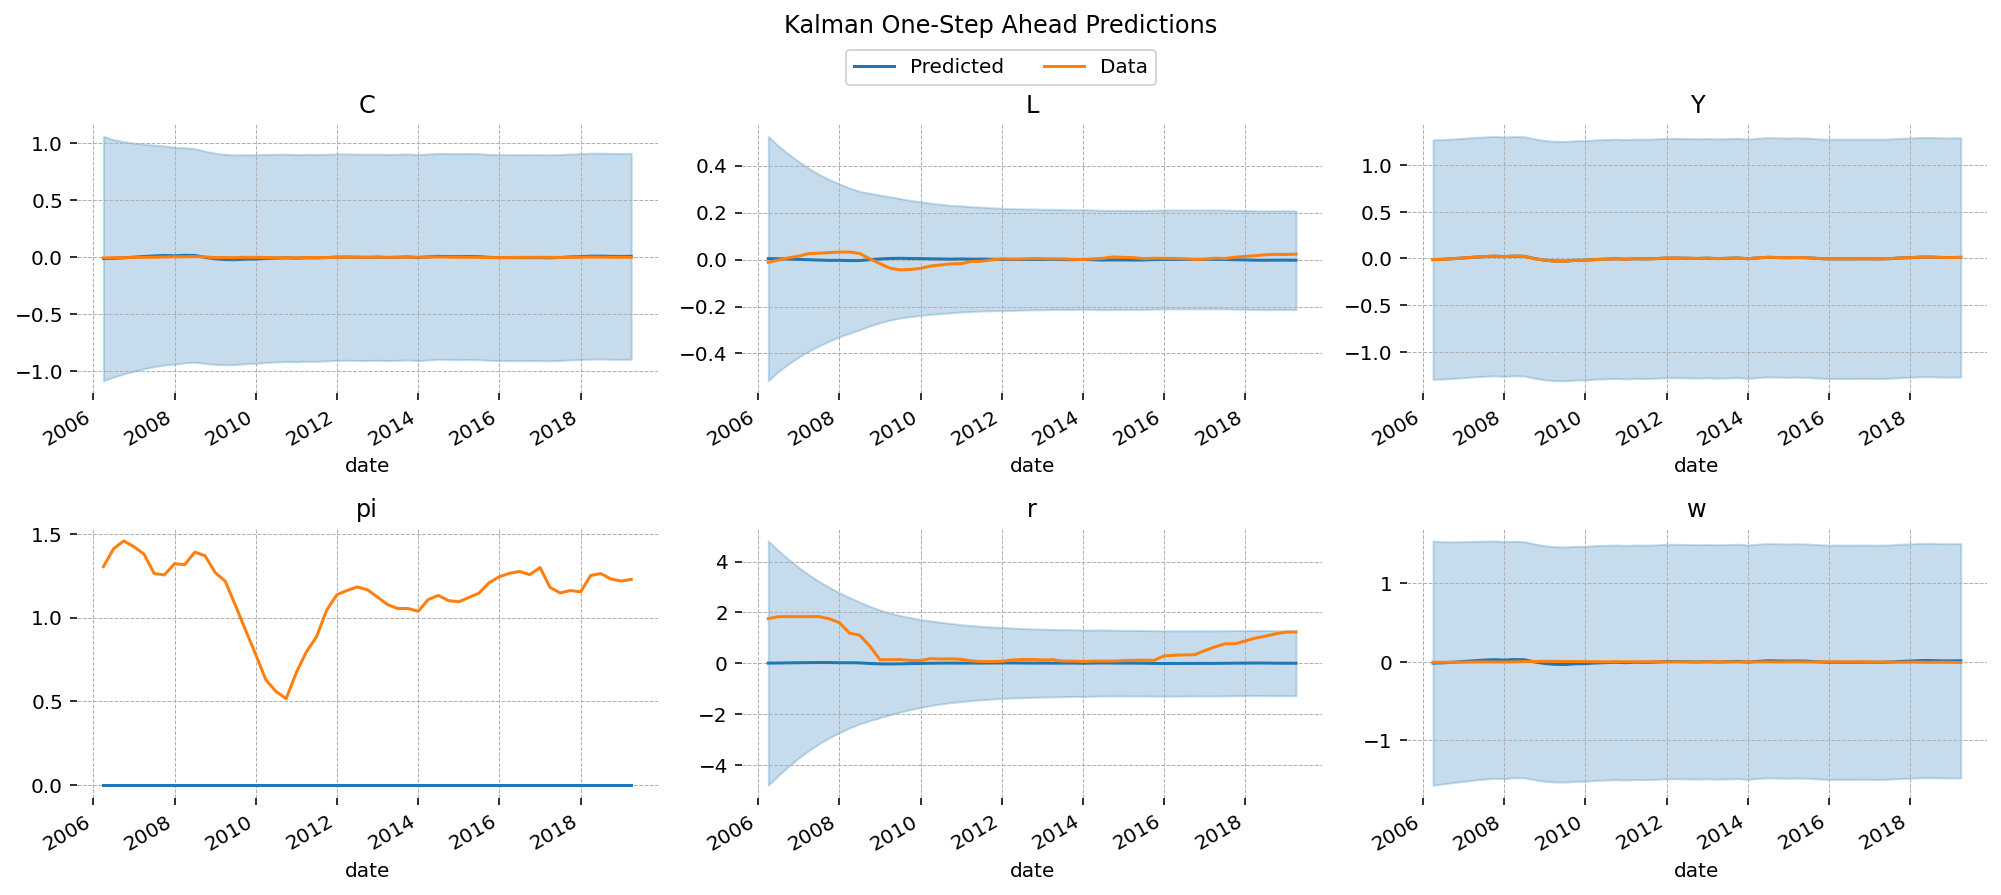

In [34]:
plot_sm_results(mod_res, train, var_names=plot_vars)

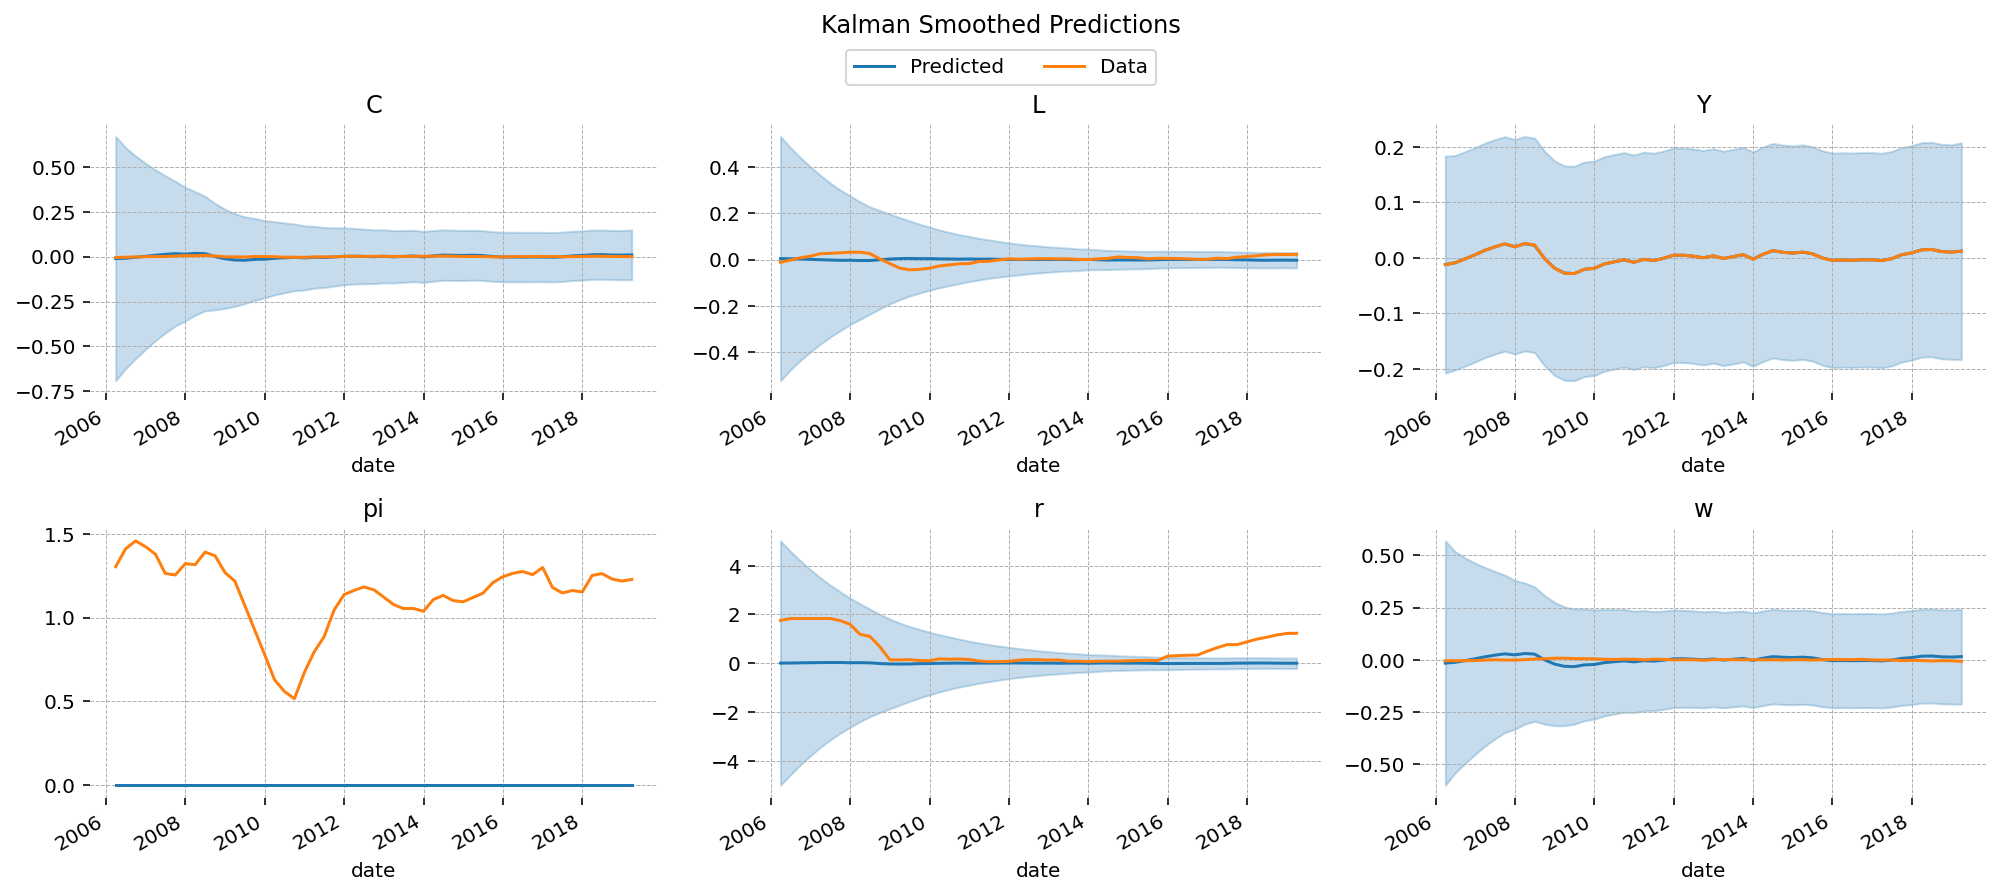

In [35]:
plot_sm_results(mod_res, train, 'smoothed', var_names=plot_vars)

In [37]:
mod_for.var_pred_mean

array([[[0.42422398, 0.48214621],
        [0.48214621, 0.58121624]],

       [[0.8262909 , 0.95720126],
        [0.95720126, 1.14250907]],

       [[1.22089606, 1.42982855],
        [1.42982855, 1.70858517]],

       [[1.60702134, 1.89808437],
        [1.89808437, 2.27644104]],

       [[1.98380312, 2.36024846],
        [2.36024846, 2.84333585]],

       [[2.35052162, 2.81481406],
        [2.81481406, 3.40679223]],

       [[2.70658997, 3.26047652],
        [3.26047652, 3.96459252]],

       [[3.05154332, 3.6961209 ],
        [3.6961209 , 4.51477133]],

       [[3.38502812, 4.12080899],
        [4.12080899, 5.05560549]],

       [[3.70679166, 4.53376609],
        [4.53376609, 5.58560203]],

       [[4.01667209, 4.93436781],
        [4.93436781, 6.10348479]],

       [[4.3145888 , 5.322127  ],
        [5.322127  , 6.60818018]],

       [[4.6005334 , 5.69668113],
        [5.69668113, 7.09880248]]])

In [39]:
mu

2019-07-01    0.011807
2019-10-01    0.011622
2020-01-01    0.011427
2020-04-01    0.011225
2020-07-01    0.011016
2020-10-01    0.010802
2021-01-01    0.010583
2021-04-01    0.010361
2021-07-01    0.010136
2021-10-01    0.009908
2022-01-01    0.009680
2022-04-01    0.009450
2022-07-01    0.009221
Freq: QS-JAN, Name: predicted_mean, dtype: float64

            predicted_mean
2019-07-01        0.011807
2019-10-01        0.011622
2020-01-01        0.011427
2020-04-01        0.011225
2020-07-01        0.011016
2020-10-01        0.010802
2021-01-01        0.010583
2021-04-01        0.010361
2021-07-01        0.010136
2021-10-01        0.009908
2022-01-01        0.009680
2022-04-01        0.009450
2022-07-01        0.009221


KeyError: 'predicted_mean'

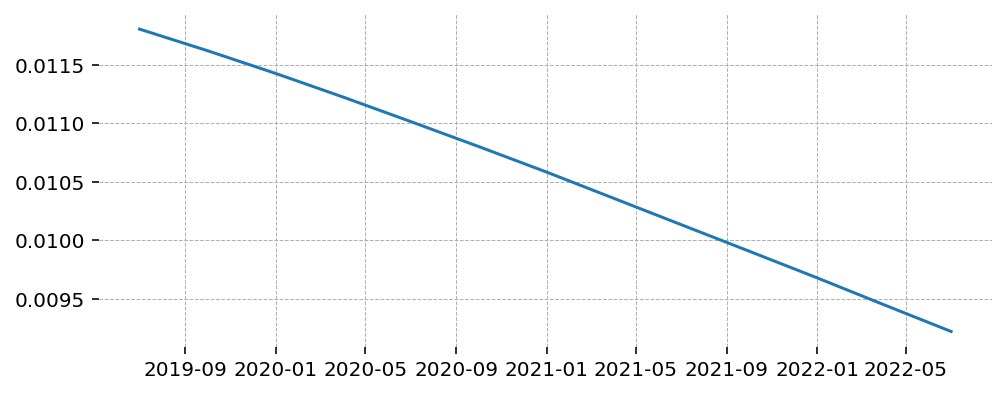

In [42]:
mod_for = mod_res.get_forecast(len(test))

mu = mod_for.predicted_mean
if type(mu) == pd.Series:
    mu = pd.DataFrame(mu)
print(mu)


for col in mu.columns:
    fig, ax = plt.subplots(figsize=(8, 3))
    # sigma = 1.96 * np.sqrt(mod_for.var_pred_mean.loc[col, col])
    ax.plot(mu[col])
    # ax.fill_between(mu[col].index, mu[col] - sigma, mu[col] + sigma, alpha=0.15)
    ax.plot(test[col])
    ax.set_title(f'Out of sample forecast on {col}')